In [1]:
import pandas as pd
import numpy as np
import pprint
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import math
from pylab import rcParams
rcParams['figure.figsize'] = 25, 13

In [2]:
from pymongo import MongoClient

from IPython.core.display import display, HTML
[display(HTML("<style>.container { width:100% !important; }</style>"))];

In [3]:
with MongoClient('mongodb://localhost:27017/') as client:
    database = client["dwh"]
    aggregated_data = database.aggregated_data
    country_codes = database.country_codes
    medal_wins = database.medal_wins
    who_ppp_2017 = database.who_ppp_2017

In [4]:
def out(Country):
    #return list(aggregated_data.find({"country": Country}))
    #values = list(aggregated_data.find({"country": 'Germany'}))[0]['medal_wins']['gold']['by_year']
    data = aggregated_data.find({"country": Country})
    x_values, y_values = get_medals(data)
    show_graph(x_values, y_values)
    return 0

In [5]:
def get_medals(data):
    # Get all gold medals, sorting the dict
    dict_gold = data[0]['medal_wins']['gold']['by_year']
    dict_gold = {k: dict_gold[k] for k in sorted(dict_gold.keys(), key=lambda x: int(x))}
    
    # Get all silver medals, sorting the dict
    dict_silver = data[0]['medal_wins']['silver']['by_year']
    dict_silver = {k: dict_silver[k] for k in sorted(dict_silver.keys(), key=lambda x: int(x))}
    
    # Get all bronze medals, sorting the dict
    dict_bronze = data[0]['medal_wins']['bronze']['by_year']
    dict_bronze = {k: dict_bronze[k] for k in sorted(dict_bronze.keys(), key=lambda x: int(x))}
    
    
    # Defining x and y values for the graph
    years = {}
    for year in sorted(set(dict_gold.keys()) | set(dict_silver.keys()) | set(dict_bronze.keys())):
        years[year] = dict_gold.get(year, 0) + dict_silver.get(year, 0) + dict_bronze.get(year, 0)

    #x_values = years.keys()
    x_values = []
    y_values = []
    for x in years:
        x_values += [x]
        y_values += [years[x]]
        
    return x_values, y_values

In [6]:
def show_graph(x_values, y_values):
    df=pd.DataFrame({'x_values': x_values, 'y_values': y_values })
    
    # plot
    plt.plot( 'x_values', 'y_values', data=df)
    plt.show()

In [7]:
interact(out, Country=[cc['country'] for cc in country_codes.find()]);

interactive(children=(Dropdown(description='Country', options=('Ukraine', 'Jordan', 'Macedonia', 'Slovakia', '…

In [8]:
all_data = list(aggregated_data.find({}))
all_data[0]['medal_wins']['bronze']['sum'] + all_data[0]['medal_wins']['silver']['sum'] + all_data[0]['medal_wins']['gold']['sum']
all_data[0]['health_expenditures']

x_values = []
y_values = []

for country in all_data:
    #print(country['country'])
    #print(country['medal_wins']['bronze']['sum'] + country['medal_wins']['silver']['sum'] + country['medal_wins']['gold']['sum'])
    #print(country['health_expenditures']['absolute'])
    
    break
    

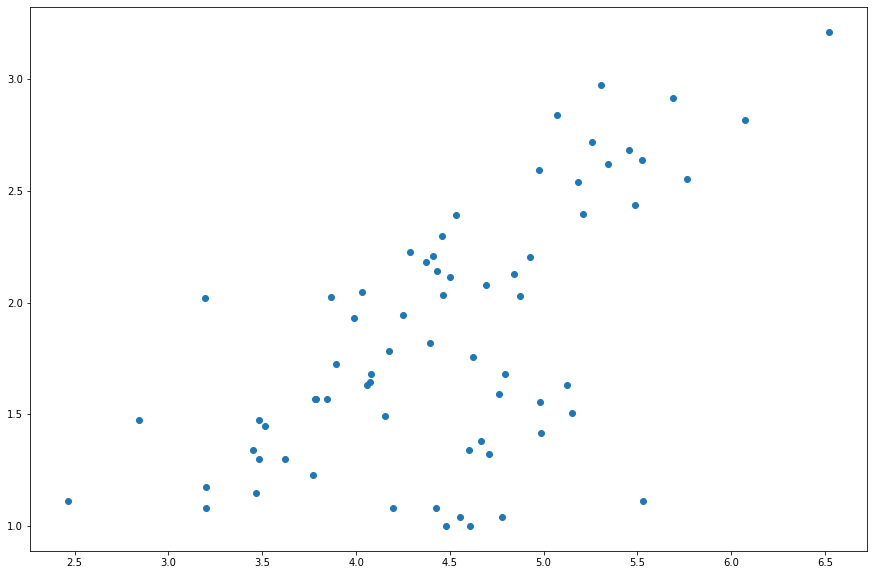

In [9]:
def medals(log=False, at_least=0, val='per_capita'):
    medals_by_expenditures = {}
    
    for color in ['gold','silver','bronze']:
        for row in aggregated_data.find():
            exp = math.log10(row['health_expenditures'][val]) if log else row['health_expenditures'][val]
            medals_by_expenditures[exp] = medals_by_expenditures.get(exp, 0) + sum(row['medal_wins'][color]['by_year'][year] for year in row['medal_wins'][color]['by_year'] if int(year) >= 2000)
     
    if log:
        for k in medals_by_expenditures: 
            medals_by_expenditures[k] = math.log10(medals_by_expenditures[k]) if medals_by_expenditures[k] else 0
        
    return {k: v for k, v in medals_by_expenditures.items() if v >= at_least}
    
data = medals(log=True, at_least=1, val='absolute')
plt.figure(figsize=(15, 10))
plt.scatter(data.keys(), data.values(), vmin=0)
plt.savefig('absolute.png')

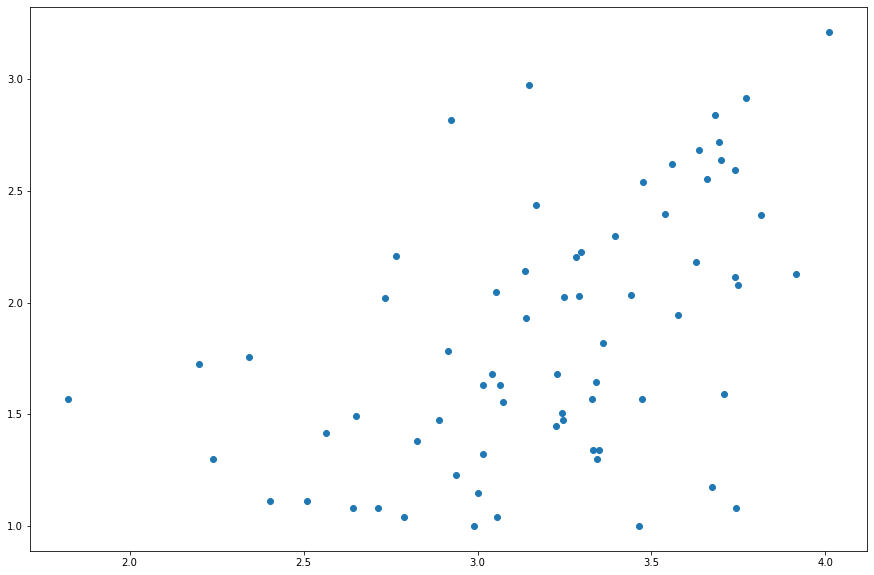

In [10]:
data = medals(log=True, at_least=1, val='per_capita')
plt.figure(figsize=(15, 10))
plt.scatter(data.keys(), data.values(), vmin=0)
plt.savefig('per_capita.png')

In [11]:
top_countries = {}
#{'countryname': {'silver':int, ..., 'sum': int, 'absolute': float, 'per_capita': float}}

for row in aggregated_data.find():
    country_name = row['country']
    
    absolute, relative = row['health_expenditures']['absolute'], row['health_expenditures']['per_capita']
    top_countries[country_name] = {
        'bronze': (b:=sum([row['medal_wins']['bronze']['by_year'][year] for year in row['medal_wins']['bronze']['by_year'] if int(year) >= 2000])),
        'silver': (s:=sum([row['medal_wins']['silver']['by_year'][year] for year in row['medal_wins']['silver']['by_year'] if int(year) >= 2000])),
        'gold': (g:=sum([row['medal_wins']['gold']['by_year'][year] for year in row['medal_wins']['gold']['by_year'] if int(year) >= 2000])),
        'sum': b+s+g,
        'absolute': absolute,
        'per_capita': relative,
    }

sorted_by_expenditure_rel = sorted(top_countries.items(), key=lambda x: x[1]['per_capita'], reverse=True)
sorted_by_expenditure_abs = sorted(top_countries.items(), key=lambda x: x[1]['absolute'], reverse=True)
sorted_by_medals = sorted(top_countries.items(), key=lambda x: x[1]['sum'], reverse=True)

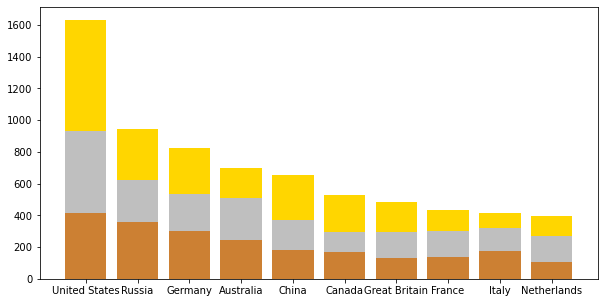

In [12]:
silver = list(x[1]['silver'] for x in sorted_by_medals[:10])
gold = list(x[1]['gold'] for x in sorted_by_medals[:10])
bronze = list(x[1]['bronze'] for x in sorted_by_medals[:10])

plt.figure(figsize=(10,5))

plt.bar(list(x[0] for x in sorted_by_medals[:10]), bronze, color=(0.80,0.50,0.20))
plt.bar(list(x[0] for x in sorted_by_medals[:10]), silver, bottom=bronze, color=(0.75,0.75,0.75))
bottom_gold = [a+b for a,b in zip(silver, bronze)]
plt.bar(list(x[0] for x in sorted_by_medals[:10]), gold, bottom=bottom_gold, color=(1.00,0.84,0.00))
plt.savefig('medals_by_color.png', dpi=150)
plt.show()

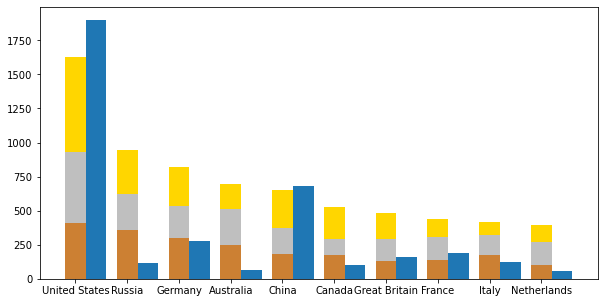

In [13]:
plt.figure(figsize=(10,5))
silver = list(x[1]['silver'] for x in sorted_by_medals[:10])
gold = list(x[1]['gold'] for x in sorted_by_medals[:10])
bronze = list(x[1]['bronze'] for x in sorted_by_medals[:10])

plt.bar(np.arange(10) + 0.4, list((x[1]['absolute'] / 1750) for x in sorted_by_medals[:10]), width=0.4)

plt.bar(list(x[0] for x in sorted_by_medals[:10]), bronze, color=(0.80,0.50,0.20), width=0.4)
plt.bar(list(x[0] for x in sorted_by_medals[:10]), silver, bottom=bronze, color=(0.75,0.75,0.75), width=0.4)
bottom_gold = [a + b for a,b in zip(silver, bronze)]
plt.bar(list(x[0] for x in sorted_by_medals[:10]), gold, bottom=bottom_gold, color=(1.00,0.84,0.00), width=0.4)
plt.savefig('medals_by_color_absolute.png', dpi=150)
plt.show()

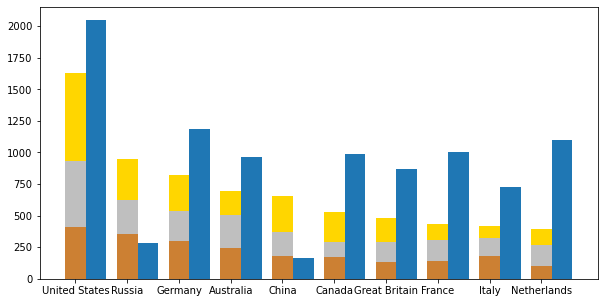

In [14]:
plt.figure(figsize=(10,5))
silver = list(x[1]['silver'] for x in sorted_by_medals[:10])
gold = list(x[1]['gold'] for x in sorted_by_medals[:10])
bronze = list(x[1]['bronze'] for x in sorted_by_medals[:10])

plt.bar(np.arange(10) + 0.4, list((x[1]['per_capita']/5) for x in sorted_by_medals[:10]), width=0.4)

plt.bar(list(x[0] for x in sorted_by_medals[:10]), bronze, color=(0.80,0.50,0.20), width=0.4)
plt.bar(list(x[0] for x in sorted_by_medals[:10]), silver, bottom=bronze, color=(0.75,0.75,0.75), width=0.4)
bottom_gold = [a + b for a,b in zip(silver, bronze)]
plt.bar(list(x[0] for x in sorted_by_medals[:10]), gold, bottom=bottom_gold, color=(1.00,0.84,0.00), width=0.4)
plt.savefig('medals_by_color_relative.png', dpi=150)
plt.show()